<a href="https://colab.research.google.com/github/dans198/AprilTag_DT/blob/main/Apple_picking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install pyrealsense2
!pip install open3d
!pip install ultralytics
!pip install torch
!pip install tensorflow
!pip install inference
!pip install roboflow

  Using cached roboflow-1.1.53-py3-none-any.whl.metadata (9.7 kB)
  Using cached idna-3.7-py3-none-any.whl.metadata (9.9 kB)
Using cached roboflow-1.1.53-py3-none-any.whl (82 kB)
Using cached idna-3.7-py3-none-any.whl (66 kB)
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.47.1 requires tokenizers<0.22,>=0.21, but you have tokenizers 0.20.3 which is incompatible.


In [1]:
import os
HOME = os.getcwd()
print("HOME:", HOME)
!git clone https://github.com/facebookresearch/segment-anything-2.git
%cd {HOME}/segment-anything-2
!pip install -e . -q

HOME: /content
Cloning into 'segment-anything-2'...
remote: Enumerating objects: 1070, done.
remote: Total 1070 (delta 0), reused 0 (delta 0), pack-reused 1070 (from 1)
Receiving objects: 100% (1070/1070), 134.70 MiB | 15.62 MiB/s, done.
Resolving deltas: 100% (376/376), done.
/content/segment-anything-2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 300.1 kB/s eta 0:00:00
  Building editable for SAM-2 (pyproject.toml) ... done


In [4]:
from inference import get_model
import supervision as sv
import cv2
from roboflow import Roboflow
API_KEY = "krcBi08AOauTOWDwib66"
MODEL_ID = "apples-in-the-lab"
rf = Roboflow(api_key = API_KEY)
project = rf.workspace().project(MODEL_ID)
model = project.version("2").model

loading Roboflow workspace...
loading Roboflow project...



0: 384x640 3 apples, 105.6ms
Speed: 4.2ms preprocess, 105.6ms inference, 432.8ms postprocess per image at shape (1, 3, 384, 640)


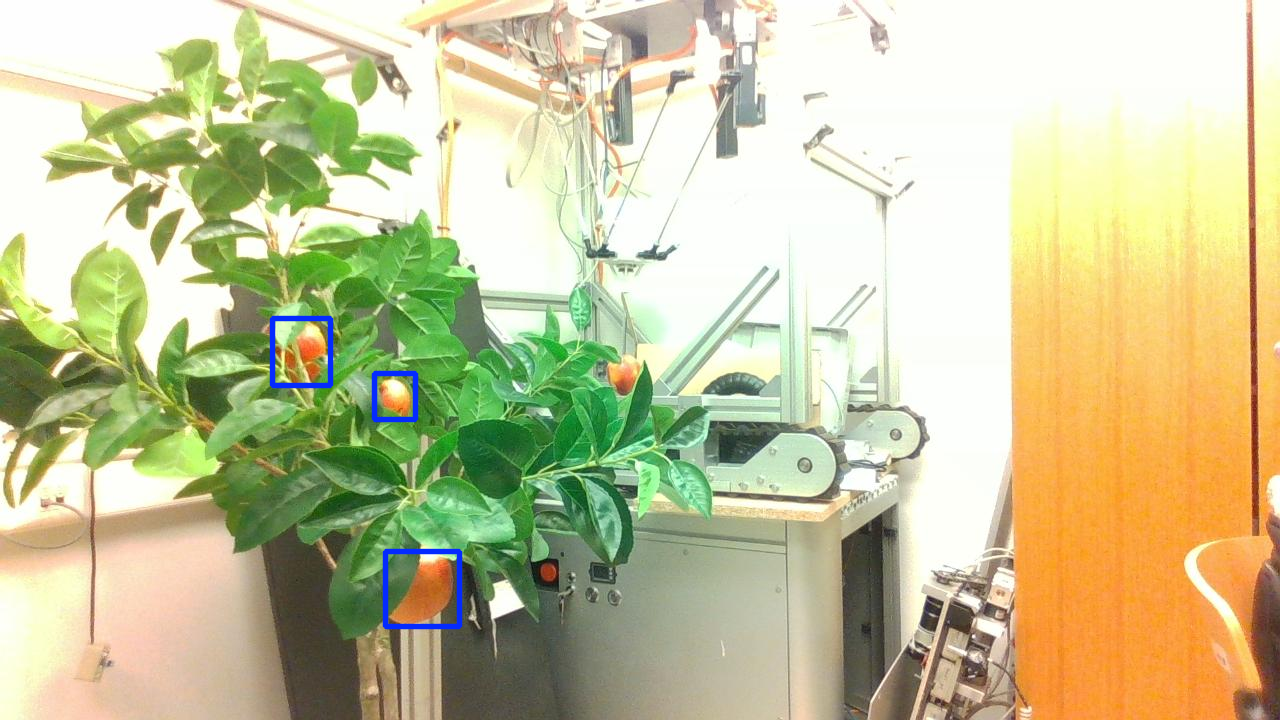

In [5]:
import pyrealsense2 as rs
import numpy as np
import cv2
from ultralytics import YOLO
import open3d as o3d
from datetime import datetime
from PIL import Image
import time

c_image_path = "/content/color_image1.jpg"
depth_path = "/content/depth_image1.png"
model_path = "/content/best.pt"
model = YOLO(model_path)
color_image = cv2.imread(c_image_path)
results = model.predict(color_image, conf=0.4)

for i, r in enumerate(results):
        # Plot results image
        im_bgr = r.plot(labels = False)  # BGR-order numpy array
        im_rgb = Image.fromarray(im_bgr[..., ::-1])  # RGB-order PIL image

        # Show results to screen
        r.show(labels = False, boxes = True)


In [6]:
import os
HOME = os.getcwd()
!mkdir -p {HOME}/checkpoints
!wget -q https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt -P {HOME}/checkpoints

Device =  cuda


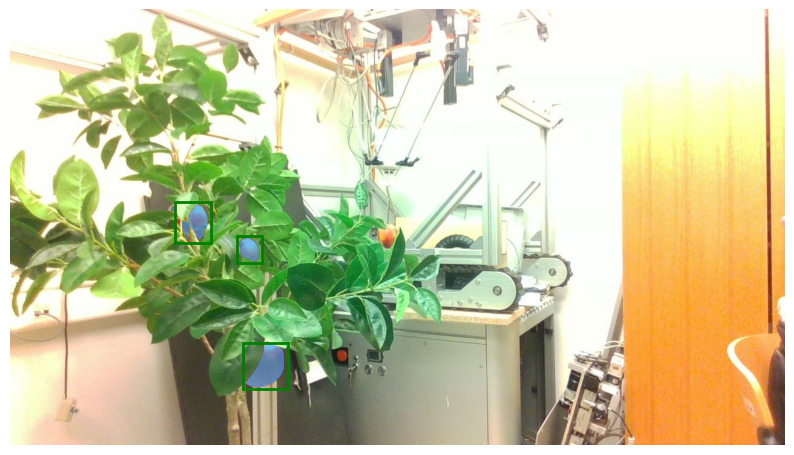

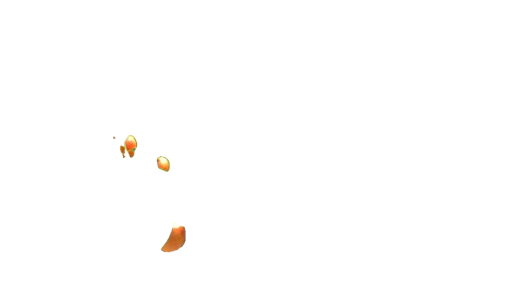

In [12]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
import torch
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

all_bboxes = []
for result in results:
  boxes = result.boxes # Boxes object for bbox outputs
  for box in boxes.xyxy.tolist():
    all_bboxes.append(box)

image = cv2.cvtColor(cv2.imread(c_image_path), cv2.COLOR_BGR2RGB)

########## SAM #############################
CHECKPOINT = "/content/{HOME}/checkpoints/sam2_hiera_large.pt"
CONFIG = "sam2_hiera_l.yaml"
sam2_model = build_sam2(CONFIG, CHECKPOINT, device='cpu', apply_postprocessing=False)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = 'cpu'
print('Device = ', device)

# mask_generator = SAM2AutomaticMaskGenerator(sam2_model)
predictor = SAM2ImagePredictor(sam2_model)

predictor.set_image(color_image)

# Convert Bounding Box to Segmentation Mask
all_masks = []
for bbox in all_bboxes:
    input_box = np.array(bbox)

    masks, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=input_box[None, :],
        multimask_output=False, )
    all_masks.append(masks[0])
all_masks = np.array(all_masks)
# print(np.shape(all_masks))

plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in all_masks:
    show_mask(mask, plt.gca())
for input_box in all_bboxes:
    show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

 # all masks on white background
new_image = np.ones_like(image) * 255
for mask in all_masks:
    # print(np.shape(mask))
    binary_mask = np.where(mask > 0.5, 1, 0)
    new_image = new_image * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]

# masks on white background
plt.imshow(new_image)
plt.axis('off')
plt.show()

Mean_depth  850.8642901813633
Mean_depth  728.1628959276018
Mean_depth  1176.185515873016
Size of filtered (2, 720, 1280)


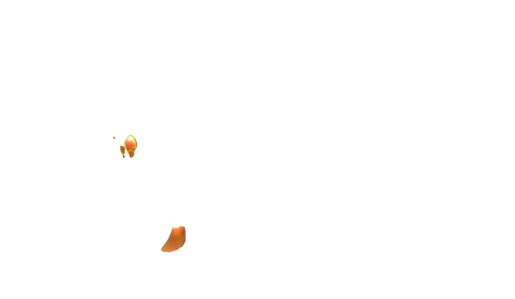

In [18]:
depth_image = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
distance = 1000
filtered_masks = []
for mask in all_masks:
    mask = mask.astype(np.uint8)
    masked_depth_image = cv2.bitwise_and(depth_image, depth_image, mask=mask)

    # Estrai i valori di profondità dove la maschera è non-zero
    depth_values = depth_image[mask == 1]

    # Calcola la profondità media dell'oggetto (o min/max a seconda di cosa preferisci)
    if depth_values.size > 0:  # Se la maschera non è vuota
        mean_depth = np.mean(depth_values)
        print('Mean_depth ',mean_depth)
        # Verifica se la profondità media è nel range desiderato
        if mean_depth <= distance:
            filtered_masks.append(mask)
filtered_masks = np.array(filtered_masks)
print('Size of filtered', filtered_masks.shape)

# Display
new_image = np.ones_like(image) * 255
for mask in filtered_masks:
    # print(np.shape(mask))
    binary_mask = np.where(mask > 0.5, 1, 0)
    new_image = new_image * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]
# masks on white background
plt.imshow(new_image)
plt.axis('off')
plt.show()

In [36]:
def is_circular(mask, circularity_threshold=0.5):
    # Check if the masks are circular
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return False, 0, 0, 0  # No contours found
    contour = max(contours, key=cv2.contourArea) # Assume the largest contour corresponds to the object of interest
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    if perimeter == 0: # Calculate the circularity
        print("radius is 0!")
        return False, 0, area, perimeter  # Avoid division by zero
    circularity = (4 * np.pi * area) / (perimeter * perimeter)
    is_circular = circularity_threshold <= circularity <= 1.0  # Check if the shape is approximately circular
    return is_circular, circularity, area, perimeter

Numero di maschere circolari trovate: 1


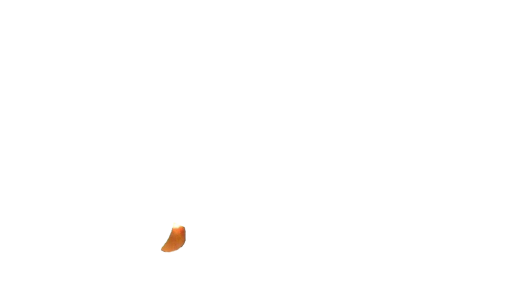

Size of circular mask: if2  (720, 1280)


In [37]:
circular_masks = []
primerna = []
best_mask = []
best_area = 0
best_nonc_mask = []
best_nonc_area = 0
for mask in filtered_masks:
    # mask_uint8 = (mask.data[0].numpy()*255).astype("uint8")
    mask_uint8 = mask.astype(np.uint8) * 255
    circular,circularity, area, perimeter = is_circular(mask_uint8)
    # print(area, best_area)
    if circular:
        circular_masks.append(mask)
        primerna.append(True)
        #print("primerna")
        if area > best_area:
            best_area = area
            best_mask = mask
            # print("better mask")
    else:
        primerna.append(False)
        #print("neprimerna")
        if area > best_nonc_area:
            best_nonc_area = area
            best_nonc_mask = mask

print(f"Numero di maschere circolari trovate: {len(circular_masks)}")

##########################
# plot just circular masks
new_image2 = np.ones_like(image) * 255
for mask in circular_masks:
    binary_mask = np.where(mask > 0.5, 1, 0)
    # binary_mask_resized = cv2.resize(binary_mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    # new_image2 = new_image2 * (1 - binary_mask_resized[..., np.newaxis]) + image * binary_mask_resized[..., np.newaxis]
    new_image2 = new_image2 * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]


# original image
# plt.imshow(image)
# plt.axis('off')
# plt.show()

# masks on white background
plt.imshow(new_image2)
plt.axis('off')
plt.show()

#############


# print("Mask detected: ", all_masks.shape[0])
if np.size(best_mask) == 0:
    best_mask = best_nonc_mask
    print('Size of circular mask: if1 ',best_mask.shape)
    print("best of the circular masks")

if np.size(best_mask) > 0:
    best_mask = best_mask.astype(np.uint8)
    print('Size of circular mask: if2 ',best_mask.shape)
else:
    print("No mask was found !!!")



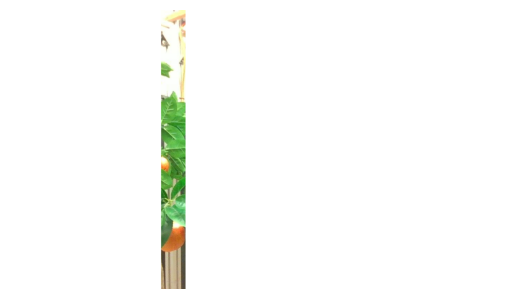

In [30]:
new_image = np.ones_like(image) * 255
for mask in best_mask:
    # print(np.shape(mask))
    binary_mask = np.where(mask > 0.5, 1, 0)
    new_image = new_image * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]
# masks on white background
plt.imshow(new_image)
plt.axis('off')
plt.show()